# Analyze NMD screen

## Load libraries and define analysis parameters

In [1]:
options(warn = -1, repr.matrix.max.rows = 15, display.matrix.max.cols = 1000)

suppressPackageStartupMessages({
  library(org.Hs.eg.db)
  library(tidyverse)
  library(rasilabRtemplates)
})

cbPalette_12 <- c(
  "#DDCC77", "#CC6677", "#6699CC", "#661100", "#117733", "#999933",
  "#332288", "#AA4499", "#44AA99", "#882255", "#88CCEE", "#999999"
)

theme_set(theme_rasilab() +
  theme(
    axis.line = element_line(color = "grey"),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.title.x = element_text(margin = margin(t = 10))
  ))

fdr_cutoff <- 0.05
p_value_cutoff <- 0.05

set.seed(111)


In [2]:
orgdb <- org.Hs.eg.db

ribi <- AnnotationDbi::select(orgdb, keytype = "GOALL", keys = c("GO:0042273", "GO:0042274"), columns = c("SYMBOL")) %>%
  as_tibble() %>%
  janitor::clean_names() %>%
  distinct(goall, symbol) %>%
  dplyr::rename(gene = symbol, go_id = goall) %>%
  mutate(annotation = if_else(go_id == "GO:0042273", "60S biogenesis", "40S biogenesis")) %>%
  filter(!str_detect(gene, "^RPL|^RPS|GNB2L1|RACK1"))

'select()' returned 1:many mapping between keys and columns



## Load gene annotations for NMD screen

In [3]:
nmd_hit_annotations <- read_csv("../annotations/nmd_hit_annotations.csv", show_col_types = FALSE) %>%
  print()

# A tibble: 113 × 2
   gene   annotation            
   <chr>  <chr>                 
 1 BRF1   tRNA metabolism       
 2 LARS1  tRNA metabolism       
 3 EPRS1  tRNA metabolism       
 4 EIF2S1 Translation initiation
 5 UPF2   Core NMD              
 6 EIF2S3 Translation initiation
 7 EIF2B3 Translation initiation
 8 EIF2B5 Translation initiation
 9 HARS1  tRNA metabolism       
10 RPS23  40S ribosome          
# … with 103 more rows


In [4]:
annotation_order <- c(
"Core NMD",
"Translation initiation",
"tRNA metabolism",
"Mitochondria",
"RNA exosome",
"Proteasome",
"60S ribosome",
"40S ribosome",
"Ribosome biogenesis"
) %>%
as_tibble_col("annotation") %>%
mutate(priority = row_number()) %>%
print()

# A tibble: 9 × 2
  annotation             priority
  <chr>                     <int>
1 Core NMD                      1
2 Translation initiation        2
3 tRNA metabolism               3
4 Mitochondria                  4
5 RNA exosome                   5
6 Proteasome                    6
7 60S ribosome                  7
8 40S ribosome                  8
9 Ribosome biogenesis           9


## Load MaGeCK gene-level results for NMD screens

In [5]:
mageck_gene <- list.files("../data/mageck/", full.names = T, recursive = T, pattern = "gene_summary.tsv$") %>%
  as_tibble_col("file") %>%
  filter(str_detect(file, "ntc|ptc"), !str_detect(file, "retained|skipped"), !str_detect(file, "ptc_bc1_total_vs"),
  !str_detect(file, "ntc.+day"), !str_detect(file, ".+polysome.+vs.+(total|light)")) %>%
  mutate(sample_name = str_extract(file, "(?<=mageck//).+(?=/mageck.)")) %>%
  separate(sample_name, c("treatment", "control"), sep = "_vs_", remove = F) %>%
  mutate(data = map(file, . %>% read_tsv(show_col_types = F))) %>%
  select(-file) %>%
  unnest(data) %>%
  janitor::clean_names() %>%
  select(-neg_lfc) %>%
  rename(lfc = pos_lfc, gene = id) %>%
  mutate(p_value = if_else(lfc > 0, pos_p_value, neg_p_value)) %>%
  mutate(fdr = if_else(lfc > 0, pos_fdr, neg_fdr)) %>%
  mutate(goodsgrna = if_else(lfc > 0, pos_goodsgrna, neg_goodsgrna)) %>%
  mutate(fdr = if_else(is.na(fdr), 1, fdr)) %>%
  print()

# A tibble: 17,488 × 19
   sample_…¹ treat…² control gene    num neg_s…³ neg_p…⁴ neg_fdr neg_r…⁵ neg_g…⁶
   <chr>     <chr>   <chr>   <chr> <dbl>   <dbl>   <dbl>   <dbl>   <dbl>   <dbl>
 1 ntc_bc1_… ntc_bc… ntc_bc… DDX4      3  1.00    1.00     1.00     2186       0
 2 ntc_bc1_… ntc_bc… ntc_bc… RNMT      4  1.00    1.00     1.00     2185       0
 3 ntc_bc1_… ntc_bc… ntc_bc… PNISR     4  1.00    1.00     1.00     2184       0
 4 ntc_bc1_… ntc_bc… ntc_bc… DYNC…     4  0.716   0.743    1.00     1501       1
 5 ntc_bc1_… ntc_bc… ntc_bc… PCDH…     4  0.0177  0.0568   0.627     196       1
 6 ntc_bc1_… ntc_bc… ntc_bc… DALR…     4  0.935   0.935    1.00     1980       0
 7 ntc_bc1_… ntc_bc… ntc_bc… SEC2…     3  0.999   0.999    1.00     2183       0
 8 ntc_bc1_… ntc_bc… ntc_bc… FXR1      4  0.140   0.282    0.967     625       2
 9 ntc_bc1_… ntc_bc… ntc_bc… HNRN…     4  0.999   0.999    1.00     2182       0
10 ntc_bc1_… ntc_bc… ntc_bc… DDX17     4  0.999   0.999    1.00     2181       0
# … 

## Load MaGeCK sgRNA-level results for NMD screens

In [6]:
mageck_sgrna <- list.files("../data/mageck/", full.names = T, recursive = T, pattern = "sgrna_summary.tsv$") %>%
  as_tibble_col("file") %>%
  filter(str_detect(file, "ntc|ptc"), !str_detect(file, "retained|skipped"), !str_detect(file, "ptc_bc1_total_vs"),
  !str_detect(file, "ntc.+day"), !str_detect(file, ".+polysome.+vs.+(total|light)")) %>%
  mutate(sample_name = str_extract(file, "(?<=mageck//).+(?=/mageck.)")) %>%
  separate(sample_name, c("treatment", "control"), sep = "_vs_", remove = F) %>%
  mutate(data = map(file, . %>% read_tsv(show_col_types = F))) %>%
  select(-file) %>%
  unnest(data) %>%
  janitor::clean_names() %>%
  print()


# A tibble: 67,543 × 18
   sample_name treat…¹ control sgrna gene  contr…² treat…³ contr…⁴ treat…⁵   lfc
   <chr>       <chr>   <chr>   <chr> <chr>   <dbl>   <dbl>   <dbl>   <dbl> <dbl>
 1 ntc_bc1_to… ntc_bc… ntc_bc… DYNC… DYNC…    43.6   2216.    43.6   2216.  5.63
 2 ntc_bc1_to… ntc_bc… ntc_bc… FXR1… FXR1     43.6   1998.    43.6   1998.  5.48
 3 ntc_bc1_to… ntc_bc… ntc_bc… RNAS… RNAS…    43.6   1938.    43.6   1938.  5.44
 4 ntc_bc1_to… ntc_bc… ntc_bc… MTER… MTER…    43.6   1821     43.6   1821   5.35
 5 ntc_bc1_to… ntc_bc… ntc_bc… SNRP… SNRPC    43.6   1538.    43.6   1538.  5.11
 6 ntc_bc1_to… ntc_bc… ntc_bc… TMA1… TMA16    43.6   1436.    43.6   1436.  5.01
 7 ntc_bc1_to… ntc_bc… ntc_bc… RDM1… RDM1     43.6   1430.    43.6   1430.  5.00
 8 ntc_bc1_to… ntc_bc… ntc_bc… FUBP… FUBP1    43.6   1415.    43.6   1415.  4.99
 9 ntc_bc1_to… ntc_bc… ntc_bc… UBC_… UBC      43.6   1408.    43.6   1408.  4.98
10 ntc_bc1_to… ntc_bc… ntc_bc… PAPO… PAPO…    43.6   1399.    43.6   1399.  4.97
# … 

## Plot alphabetical list of NMD hits

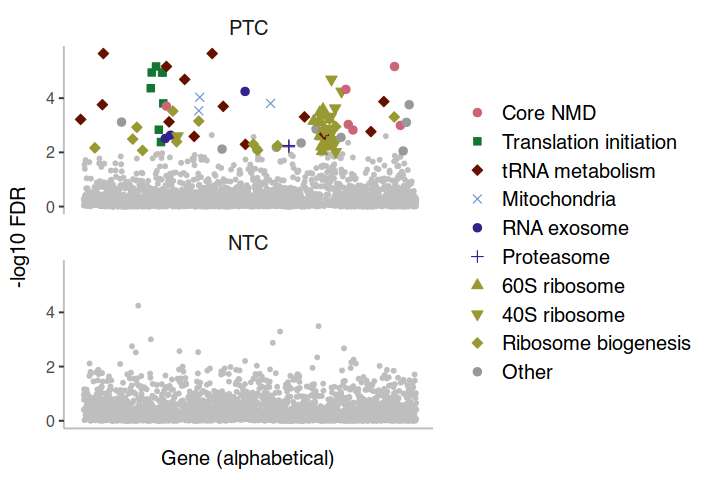

In [8]:
options(repr.plot.width = 6, repr.plot.height = 4)

plot_data <- mageck_gene %>%
  filter(str_detect(sample_name, "bc1.+bc2")) %>%
  mutate(reporter = str_extract(sample_name, "ptc|ntc")) %>%
  left_join(nmd_hit_annotations, by = "gene") %>%
  left_join(annotation_order, by = "annotation") %>%
  mutate(priority = if_else(is.na(annotation), as.integer(10), priority)) %>%
  mutate(annotation = if_else(is.na(annotation), "Other", as.character(annotation))) %>%
  mutate(annotation = fct_reorder(annotation, priority)) %>%
  group_by(reporter) %>%
  arrange(gene) %>%
  mutate(x = row_number()) %>%
  ungroup() %>%
  mutate(reporter = toupper(reporter))

plot_data %>%
  ggplot(aes(x = x, y = -log10(pos_p_value), color = annotation, fill = annotation)) +
  facet_wrap(~ fct_rev(reporter), ncol = 1) +
  geom_point(size = 1, alpha = 1, data = plot_data %>% filter(fdr > fdr_cutoff | lfc < 0), color = "grey", fill = "grey") +
  geom_point(aes(shape = annotation),
    size = 2, alpha = 1,
    data = plot_data %>% filter(fdr < fdr_cutoff & lfc > 0),
    position = position_jitter(height = 0, width = 50, seed = 11)
  ) +
  scale_color_manual(values = cbPalette_12[c(2,5,4, 3,7, 7, 6,6,6,12)]) +
  scale_fill_manual(values = cbPalette_12[c(2,5,4, 3, 7, 7, 6,6,6,12)]) +
  scale_shape_manual(values = rep(c("circle filled", "square filled", "diamond filled", "cross", "circle filled", "plus", "triangle filled", "triangle down filled", "diamond filled"), 5)) +
  labs(x = "Gene (alphabetical)", y = "-log10 P-value") +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), legend.title = element_blank())

ggsave("../figures/nmd_alphabetic.pdf", width = 6, height = 4, units = "in")


In [9]:
plot_data  %>% 
  filter(pos_fdr <= fdr_cutoff) %>%
  group_by(reporter) %>% 
  count()

reporter,n
<chr>,<int>
PTC,90


In [11]:
plot_data  %>% 
  filter(gene == "SMG6")

sample_name,treatment,control,gene,num,neg_score,neg_p_value,neg_fdr,neg_rank,neg_goodsgrna,⋯,pos_rank,pos_goodsgrna,lfc,p_value,fdr,goodsgrna,reporter,annotation,priority,x
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<int>,<int>
ntc_bc1_total_vs_ntc_bc2_total,ntc_bc1_total,ntc_bc2_total,SMG6,3,0.014374,0.037858,0.544457,175,1,⋯,896,2,0.58005,0.384920,0.987840,2,NTC,Other,10,1769
ptc_day7_dmso_bc1_total_vs_ptc_day7_dmso_bc2_total,ptc_day7_dmso_bc1_total,ptc_day7_dmso_bc2_total,SMG6,4,0.989100,0.989300,NA,2082,0,⋯,114,4,0.87965,0.015393,0.066274,4,PTC,Other,10,1769


## Scatter plot of above to show effect size

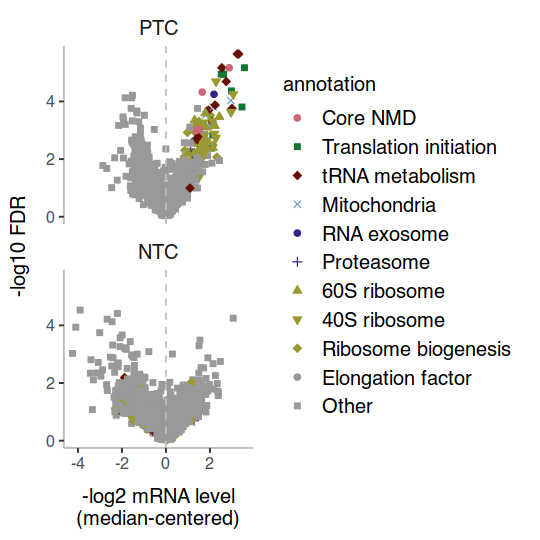

In [13]:
options(repr.plot.width = 4.5, repr.plot.height = 4.5)

plot_data %>%
  ggplot(aes(x = lfc, y = -log10(p_value), color = annotation, fill = annotation, shape = annotation)) +
  facet_wrap(~ fct_rev(reporter), ncol = 1) +
  geom_point() +
  geom_vline(xintercept = 0, linetype = 2, linewidth = 0.5, color = "grey") +
  scale_color_manual(values = cbPalette_12[c(2,5,4, 3,7, 7, 6,6,6,12, 12)]) +
  scale_fill_manual(values = cbPalette_12[c(2,5,4, 3, 7, 7, 6,6,6,12, 12)]) +
  scale_shape_manual(values = rep(c("circle filled", "square filled", "diamond filled", "cross", "circle filled", "plus", "triangle filled", "triangle down filled", "diamond filled"), 5)) +
  labs(x = "-log2 mRNA level\n(median-centered)", y = "-log10 P-value")

ggsave("../figures/nmd_volcano.pdf", width = 4.5, height = 4.5, units = "in")

## Highlight data for EIF2, EIF3, EIF4F

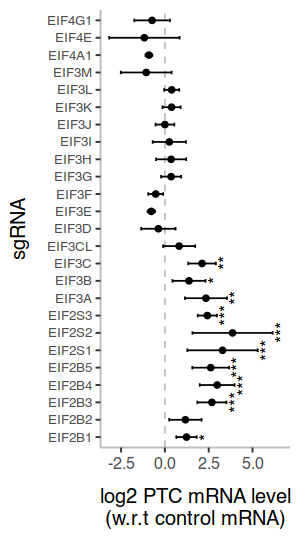

In [9]:
options(repr.plot.width = 2.5, repr.plot.height = 4.5)

mageck_sgrna  %>% 
  filter(str_detect(gene, "^EIF2S|^EIF2B|^EIF2B|^EIF3|EIF4A1|EIF4E$|EIF4G1")) %>% 
  filter(str_detect(sample_name, "ptc.+bc1.+bc2")) %>% 
  group_by(gene) %>% 
  summarize(mean_lfc = mean(lfc),  sd_lfc = sd(lfc), n = n()) %>%
  left_join(mageck_gene %>% filter(str_detect(sample_name, "ptc.+bc1.+bc2"))  %>% select(gene, pos_p_value), by = "gene") %>%
  mutate(sig = case_when(
    pos_p_value < 0.001 ~ "***",
    pos_p_value < 0.01 ~ "**",
    pos_p_value < 0.05 ~ "*",
    TRUE ~ "")
  ) %>% 
  ggplot(aes(x = gene, y = mean_lfc)) +
  geom_hline(yintercept = 0, linetype = 2, color = "grey") +
  geom_point() +
  geom_errorbar(aes(ymin = mean_lfc - sd_lfc, ymax = mean_lfc + sd_lfc), width = 0.2) +
  geom_text(aes(label = sig, y = mean_lfc + sd_lfc + 0.5), angle = 90) +
  labs(x = "sgRNA", y = "log2 PTC mRNA level\n(w.r.t control mRNA)") +
  coord_flip() +
  theme(axis.text.y = element_text(size = 8))

ggsave("../figures/ptc_mrna_eif2_eif3_eif4.pdf", width = 2.5, height = 4.5, units = "in")

## Highlight fold changes for NMD hit gene groups

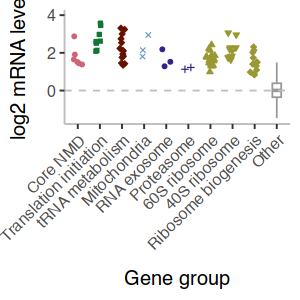

In [10]:
options(repr.plot.width = 2.5, repr.plot.height = 2.5)

plot_data %>%
  filter(reporter == "PTC") %>%
  ggplot(aes(x = annotation, y = lfc, color = annotation)) +
  geom_point(data = plot_data  %>% filter(annotation != "Elongation factor"), show.legend = F, shape = "circle", alpha = 0) +
  geom_boxplot(data = plot_data  %>% filter(annotation == "Other"), 
  show.legend = F, outlier.shape = NA, width = 0.4, alpha = 0.2) +
  geom_point(aes(shape = annotation, fill = annotation),
    size = 1,
    data = plot_data %>% filter(annotation != "Other", pos_fdr < fdr_cutoff),
    position = position_jitter(height = 0, width = 0.2, seed = 111),
    show.legend = F
  ) +
  geom_hline(aes(yintercept = 0), linetype = 2, linewidth = 0.5, color = "grey") +
  scale_color_manual(values = cbPalette_12[c(2,5,4, 3,7, 7, 6,6,6,12)]) +
  scale_fill_manual(values = cbPalette_12[c(2,5,4, 3, 7, 7, 6,6,6,12)]) +
  scale_shape_manual(values = rep(c("circle filled", "square filled", "diamond filled", "cross", "circle filled", "plus", "triangle filled", "triangle down filled", "diamond filled"), 5)) +
  scale_y_continuous(limits = c(-1.5, 4)) +
  labs(y = "log2 mRNA level", x = "Gene group") +
  theme(legend.title = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1))

ggsave("../figures/nmd_hits_jitter.pdf", width = 2.5, height = 2.5, units = "in")


## NMD + ISRIB / GCN2 hits as volcano plot

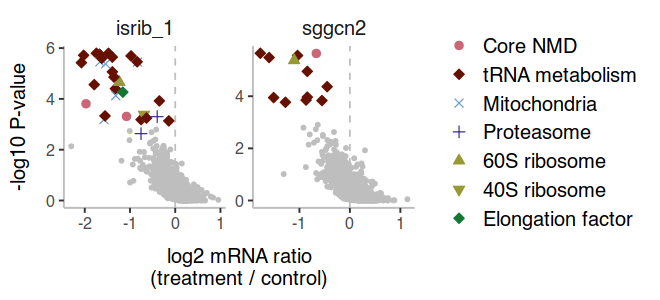

In [23]:
options(repr.plot.width = 5.5, repr.plot.height = 2.5)

fdr_cutoff <- 0.01
plot_data <- mageck_gene %>%
  filter(str_detect(sample_name, "gcn2_|isrib_1")) %>%
  mutate(reporter = str_extract(sample_name, "ptc|ntc")) %>%
  mutate(treatment = str_extract(sample_name, "isrib_1|sggcn2")) %>%
  left_join(nmd_hit_annotations, by = "gene") %>%
  left_join(annotation_order, by = "annotation") %>%
  mutate(priority = if_else(is.na(annotation), as.integer(10), priority)) %>%
  mutate(annotation = if_else(is.na(annotation), "Other", as.character(annotation))) %>%
  mutate(annotation = fct_reorder(annotation, priority)) %>%
  mutate(reporter = toupper(reporter))

plot_data %>%
  ggplot(aes(x = lfc, y = -log10(neg_p_value))) +
  facet_wrap(~treatment, ncol = 3, scales = "free") +
  geom_vline(xintercept = 0, linetype = 2, linewidth = 0.5, color = "grey") +
  geom_point(size = 1, alpha = 1, data = plot_data %>% filter(fdr > fdr_cutoff), color = "grey") +
  geom_point(aes(shape = annotation, color = annotation, fill = annotation),
    size = 2, alpha = 1,
    data = plot_data %>% filter(fdr < fdr_cutoff),
    position = position_jitter(height = 0.3, width = 0.3, seed = 11)
  ) +
  scale_x_continuous(breaks = scales::pretty_breaks(n = 3)) +
  scale_color_manual(values = cbPalette_12[c(2,4, 3,7, 6,6,5,12)]) +
  scale_fill_manual(values = cbPalette_12[c(2,4, 3, 7, 6,6,5,12)]) +
  scale_shape_manual(values = rep(c("circle filled", "diamond filled", "cross", "plus", "triangle filled", "triangle down filled", "diamond filled"), 5)) +
  labs(x = "log2 mRNA ratio\n(treatment / control)", y = "-log10 P-value") +
  theme(legend.title = element_blank())

ggsave("../figures/nmd_gcn1_isrib_volcano.pdf", width = 6, height = 2.5, units = "in")


In [33]:
plot_data  %>% 
  filter(treatment == "sggcn2", fdr < 0.01, lfc < 0) 

sample_name,treatment,control,gene,num,neg_score,neg_p_value,neg_fdr,neg_rank,neg_goodsgrna,⋯,pos_fdr,pos_rank,pos_goodsgrna,lfc,p_value,fdr,goodsgrna,reporter,annotation,priority
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<int>
ptc_sggcn2_bc1_total_vs_ptc_sgcontrol_bc1_total,sggcn2,ptc_sgcontrol_bc1_total,KARS1,4,2.7290e-05,9.7379e-05,0.002856,9,3,⋯,NA,333,1,-0.84699,9.7379e-05,0.002856,3,PTC,tRNA metabolism,3
ptc_sggcn2_bc1_total_vs_ptc_sgcontrol_bc1_total,sggcn2,ptc_sgcontrol_bc1_total,CARS1,4,1.9071e-05,7.4733e-05,0.002541,8,3,⋯,NA,1602,1,-1.40790,7.4733e-05,0.002541,3,PTC,tRNA metabolism,3
ptc_sggcn2_bc1_total_vs_ptc_sgcontrol_bc1_total,sggcn2,ptc_sgcontrol_bc1_total,RARS1,4,3.9065e-06,2.0382e-05,0.000924,6,3,⋯,NA,1816,0,-0.79119,2.0382e-05,0.000924,3,PTC,tRNA metabolism,3
ptc_sggcn2_bc1_total_vs_ptc_sgcontrol_bc1_total,sggcn2,ptc_sgcontrol_bc1_total,EPRS1,4,4.5075e-05,1.4720e-04,0.003337,12,3,⋯,NA,1823,0,-0.68964,1.4720e-04,0.003337,3,PTC,tRNA metabolism,3
ptc_sggcn2_bc1_total_vs_ptc_sgcontrol_bc1_total,sggcn2,ptc_sgcontrol_bc1_total,FARSB,4,2.9619e-05,1.0644e-04,0.002856,10,4,⋯,NA,2171,0,-0.74113,1.0644e-04,0.002856,4,PTC,tRNA metabolism,3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ptc_sggcn2_bc1_total_vs_ptc_sgcontrol_bc1_total,sggcn2,ptc_sgcontrol_bc1_total,TRNT1,3,3.0317e-05,1.1550e-04,0.002856,11,3,⋯,NA,2182,0,-1.03960,1.1550e-04,0.002856,3,PTC,tRNA metabolism,3
ptc_sggcn2_bc1_total_vs_ptc_sgcontrol_bc1_total,sggcn2,ptc_sgcontrol_bc1_total,RPL12,4,3.1746e-07,2.2646e-06,0.000123,4,4,⋯,NA,2183,0,-0.95777,2.2646e-06,0.000123,4,PTC,60S ribosome,7
ptc_sggcn2_bc1_total_vs_ptc_sgcontrol_bc1_total,sggcn2,ptc_sgcontrol_bc1_total,UPF2,4,1.4880e-08,2.2646e-06,0.000123,3,4,⋯,NA,2184,0,-0.40027,2.2646e-06,0.000123,4,PTC,Core NMD,1


## Read GORILLA GO terms

In [12]:
gorilla <- read_csv("../data/gorilla/ptc_day7_dmso_bc1_total_vs_ptc_day7_dmso_bc2_total.csv", show_col_types = F) %>% 
  janitor::clean_names() %>% 
  mutate(enrichment = str_extract(enrichment_n_b_n_b, "\\d+\\.\\d+")) %>%
  select(-genes, -enrichment_n_b_n_b, -p_value) %>% 
  print()

# A tibble: 175 × 6
   go_term    description                       fdr_q_…¹ ontol…² direc…³ enric…⁴
   <chr>      <chr>                                <dbl> <chr>   <chr>   <chr>  
 1 GO:0006413 translational initiation          2.42e-26 Process Up      7.70   
 2 GO:0000184 nuclear-transcribed mRNA catabol… 5.24e-26 Process Up      4.46   
 3 GO:0006614 SRP-dependent cotranslational pr… 1.8 e-25 Process Up      4.99   
 4 GO:0019083 viral transcription               1.35e-25 Process Up      4.99   
 5 GO:0006613 cotranslational protein targetin… 6.58e-25 Process Up      4.88   
 6 GO:0070972 protein localization to endoplas… 1.31e-24 Process Up      4.82   
 7 GO:0072599 establishment of protein localiz… 1.13e-24 Process Up      4.82   
 8 GO:0045047 protein targeting to ER           9.85e-25 Process Up      4.82   
 9 GO:0006612 protein targeting to membrane     2.06e-24 Process Up      4.77   
10 GO:0090150 establishment of protein localiz… 4.71e-22 Process Up      4.43   
# … with

## Show selected GO terms enriched in downregulated genes

In [13]:
subset_go_terms <- c(
'GO:0006413' = 'translational initiation',
'GO:0000184' = 'nuclear-transcribed mRNA catabolic process, nonsense-mediated decay',
'GO:0034198' = 'cellular response to amino acid starvation',
'GO:0036499' = 'PERK-mediated unfolded protein response',
'GO:0042254' = 'ribosome biogenesis',
'GO:0044391' = 'ribosomal subunit',
'GO:0005851' = 'eukaryotic translation initiation factor 2B complex',
'GO:0005850' = 'eukaryotic translation initiation factor 2 complex',
NULL
)

gorilla  %>% 
  filter(go_term %in% names(subset_go_terms)) %>%
  select(go_term, description, fdr_q_value, enrichment)

go_term,description,fdr_q_value,enrichment
<chr>,<chr>,<dbl>,<chr>
GO:0006413,translational initiation,2.42e-26,7.70
GO:0000184,"nuclear-transcribed mRNA catabolic process, nonsense-mediated decay",5.24e-26,4.46
GO:0034198,cellular response to amino acid starvation,1.02e-02,199.33
GO:0036499,PERK-mediated unfolded protein response,1.40e-02,107.33
GO:0042254,ribosome biogenesis,3.19e-02,2.40
GO:0044391,ribosomal subunit,7.64e-14,2.91
GO:0005851,eukaryotic translation initiation factor 2B complex,4.19e-07,155.04
GO:0005850,eukaryotic translation initiation factor 2 complex,9.50e-05,104.65
